Episode 200/200. Longueur:214

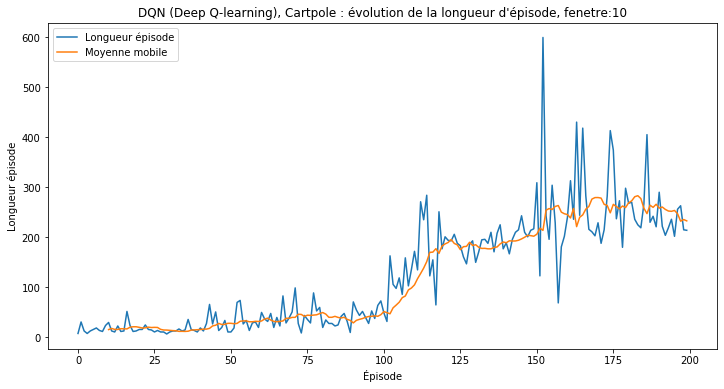

In [2]:
%matplotlib inline
# -*- coding: utf-8 -*-
"""
Deep Q-learning avec cibles-Q fixes
Cartpole-v0, Etat natif de Gym 

"""
import gym
import random
import numpy as np
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from PIL import Image
import sys

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

random.seed(42)
env = gym.make('CartPole-v0').unwrapped

Observation = namedtuple('Observation',
                        ('etat', 'action', 'etat_suivant', 'recompense'))
class HistoriqueObservations(object):
    """ Stockage de la liste des observations pour l'apprentissage 
        Mémoire circulaire pour limiter à taille_memoire"""
    def __init__(self, taille_memoire):
        self.taille_memoire = taille_memoire
        self.indice_courant = 0
        self.liste_observations = []


    def ajouter_historique(self, *args):
        """AJoutee une observation. Écriture circulaire."""
        if len(self.liste_observations) < self.taille_memoire:
            self.liste_observations.append(None)
        self.liste_observations[self.indice_courant] = Observation(*args)
        self.indice_courant = (self.indice_courant + 1) % self.taille_memoire

    def mini_lot_observations(self, taille_mini_lot):
        return random.sample(self.liste_observations, taille_mini_lot)

    def __len__(self):
        return len(self.liste_observations)
    

        
class RNAQ(nn.Module):
    def __init__(self,taille_couche_cachee=164,nb_actions_y=2):
        nn.Module.__init__(self)
        self.l1 = nn.Linear(4, taille_couche_cachee)
        self.l2 = nn.Linear(taille_couche_cachee, nb_actions_y)

    def forward(self, x):
        x = F.relu(self.l1(x))
        x = self.l2(x)
        return x

# Initaliser le RNAQ et RNACible
n_actions = env.action_space.n
rnaq = RNAQ(taille_couche_cachee=164,nb_actions_y=2)
rnaq_cible = RNAQ(taille_couche_cachee=164,nb_actions_y=2)
rnaq_cible.load_state_dict(rnaq.state_dict())
rnaq_cible.eval()

optimiseur = optim.Adam(rnaq.parameters(), 0.001)
liste_observations = HistoriqueObservations(10000)

nombre_etapes_accomplies = 0

def choisir_action(etat,epsilon):
    """ Choisir l'action max Q (politique e-vorace) à partir de rnaq"""
    unif_01 = random.uniform(0, 1)
    if unif_01 > epsilon:
        with torch.no_grad():
            return rnaq(etat).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[random.randrange(n_actions)]],dtype=torch.long)

durees_par_episode = []

def afficher_longueur_episode(longueur_episode, fenetre=10):
    """
    Afficher l'évolution des longueurs d'épisodes avec le temps
    """
    plt.figure(figsize=(12,6))
    plt.plot(longueur_episode,label="Longueur épisode")
    longueur_moyenne_fenetre=[longueur_episode[i:i+fenetre].mean() for i in range(longueur_episode.shape[0]-fenetre)]
    plt.plot(np.arange(fenetre,longueur_episode.shape[0]),longueur_moyenne_fenetre,label="Moyenne mobile")
    plt.xlabel("Épisode")
    plt.ylabel("Longueur épisode")
    plt.title("DQN (Deep Q-learning), Cartpole : évolution de la longueur d'épisode, fenetre:"+str(fenetre))
    plt.legend(loc='upper left')
    plt.show()

def optimisation_RNAQ(taille_mini_lot = 16, gamma=1.0):
    if len(liste_observations) < taille_mini_lot:
        return
    observations = liste_observations.mini_lot_observations(taille_mini_lot)
    # Transposer le mini_lot
    mini_lot = Observation(*zip(*observations))

    # masque_non_final[i] est True si etat[i] n'est pas final
    masque_non_final = torch.tensor(tuple(map(lambda s: s is not None,
                                          mini_lot.etat_suivant)),dtype=torch.bool)
    non_final_etat_suivants = torch.cat([s for s in mini_lot.etat_suivant if s is not None])
    mini_lot_etats = torch.cat(mini_lot.etat)
    mini_lot_actions = torch.cat(mini_lot.action)
    mini_lot_recompenses = torch.cat(mini_lot.recompense)

    # Chercher la valeur de Q(s,a) pour l'action a qui a été choisie selon l'historique
    mini_lot_Q = rnaq(mini_lot_etats).gather(1, mini_lot_actions)

    # Calculer la valeur cible (R+maxQ) selon la politique cible (Q est 0 si état final)
    mini_lot_Q_suivant = torch.zeros(taille_mini_lot)
    mini_lot_Q_suivant[masque_non_final] = rnaq_cible(non_final_etat_suivants).max(1)[0].detach()
    mini_lot_Q_cibles = (mini_lot_Q_suivant * gamma) + mini_lot_recompenses

    # Calculer l'erreur Huber
    #cout = F.smooth_l1_loss(mini_lot_Q, mini_lot_Q_cibles.unsqueeze(1))
    cout = F.mse_loss(mini_lot_Q, mini_lot_Q_cibles.unsqueeze(1))

    # Retropropagation
    optimiseur.zero_grad()
    cout.backward()
    for parametre in rnaq.parameters(): # Limiter les gradients (clip) pour stabiliser l'optimisation
        parametre.grad.data.clamp_(-1, 1)
    optimiseur.step()
    
def optimiser_DQN(env, nombre_episodes=20,  gamma=1.0, alpha=0.1, epsilon_max=1, epsilon_min=0.05,
                  epsilon_taux_decroissance = 0.005):    
    longueur_episode = np.zeros(nombre_episodes)
    for i_episode in range(nombre_episodes):
        etat=env.reset() # Initialiser l'environnement et l'état
        etat = torch.FloatTensor([etat])
        # Calculer epsilon
        epsilon = epsilon_min + (epsilon_max - epsilon_min)*np.exp(-epsilon_taux_decroissance*i_episode) 

        compteur_action = 0
 
        for t in count():
            #env.render()
            compteur_action +=1
            action = choisir_action(etat,epsilon) # Sélectionner et exécuter l'action
            etat_suivant, recompense, fin_episode, _ = env.step(action.item())
            recompense = torch.tensor([recompense])
            etat_suivant = torch.FloatTensor([etat_suivant])
            if fin_episode:
                etat_suivant = None

            # Ajouter l'observation à l'historique
            liste_observations.ajouter_historique(etat, action,etat_suivant,recompense)
            etat = etat_suivant
            
            optimisation_RNAQ() # Optimiser le RNAQ avec un mini-lot
            if fin_episode:
                longueur_episode[i_episode] = t
                break
        # Mettre à jouer le RNAQcible selon FREQUENCE_MAJ_RNAQ_CIBLE 
        if i_episode % 10 == 0:
            rnaq_cible.load_state_dict(rnaq.state_dict())
            
        print("\rEpisode {}/{}. Longueur:{}".format(i_episode+1, nombre_episodes, t), end="")
        #sys.stdout.flush()

    return longueur_episode

longueur_episode = optimiser_DQN(env, nombre_episodes=200,gamma=1,alpha=0.1,epsilon_max=1,epsilon_min=0.05,
                  epsilon_taux_decroissance = 0.01)

env.close()

afficher_longueur_episode(longueur_episode)







